## Clustering-specific preprocessing

In [1]:
# turning off warnings for submission purposes
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
import tensorflow as tf
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, Normalizer

rootpath = '..'

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
data = pd.read_csv(f'{rootpath}/data/preprocessed/music_data.csv')

data.drop(['year_released', 'duration', 'artist_id', 'album_id'], axis=1, inplace=True)
audio_features = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'speechiness', 'tempo', 'valence']

### Identify main genres and club minor genres with main ones

In [3]:
# main genre is defined as any genre with a frequency higher than the media
genre_freq = data.groupby('genres_top').agg({'genres_top':'count'})['genres_top']
cutoff = genre_freq.median()
major_genres = genre_freq[genre_freq > cutoff].index.values
minor_genres = genre_freq[genre_freq <= cutoff].index.values
print("Major genres: {} \nMinor Genres: {}".format(major_genres, minor_genres))

Major genres: ['Classical' 'Electronic' 'Folk' 'Hip-Hop' 'Jazz' 'Old-Time / Historic'
 'Pop' 'Rock'] 
Minor Genres: ['Blues' 'Country' 'Easy Listening' 'Experimental' 'Instrumental'
 'International' 'Soul-RnB' 'Spoken']


In [4]:
# remove generic genres - historic and experimental that cause noise
data = data[data['genres_top'] != 'Experimental']
data = data[data['genres_top'] != 'Old-Time / Historic']


# group by 'genres_top' and calculate mean for audio features
genre_groupby = data[audio_features+['genres_top']].groupby('genres_top').mean()
# reset index and rename 'genres_top' to 'cluster'
clusters = genre_groupby.reset_index().rename(columns={'genres_top':'cluster'})

# filter minor and major clusters
minor_clusters = clusters[clusters['cluster'].isin(minor_genres)]
major_clusters = clusters[clusters['cluster'].isin(major_genres)]
# create a dictionary to store new genres
new_genres = {genre: genre for genre in major_genres}

# iterate through minor clusters
for index, row in minor_clusters.iterrows():
    genre = row['cluster']
    genre_coordinates = row[audio_features].values
    genre_coordinates_other = major_clusters[audio_features].values

    # choose closest major genre as the one with minimum distance from the current minor genre
    distances = [np.linalg.norm(genre_coordinates - c) for c in genre_coordinates_other]
    min_distance = min(distances)
    closest_genre = major_clusters.iloc[np.argmin(distances)]['cluster']
    print("minor genre: {}, closest major genre: {}, distance: {}".format(genre, closest_genre, min_distance))

    # reassign genre value
    data.loc[data['genres_top'] == genre, 'genres_top'] = closest_genre
    new_genres[closest_genre] += "/" + genre

print(data.groupby('genres_top').agg({'genres_top':'count'})['genres_top'])

minor genre: Blues, closest major genre: Folk, distance: 2.261544424476276
minor genre: Country, closest major genre: Rock, distance: 1.4411055353402749
minor genre: Easy Listening, closest major genre: Electronic, distance: 0.4797921416794112
minor genre: Instrumental, closest major genre: Hip-Hop, distance: 0.5196530220858202
minor genre: International, closest major genre: Electronic, distance: 1.1886337450059727
minor genre: Soul-RnB, closest major genre: Pop, distance: 0.29882555103298225
minor genre: Spoken, closest major genre: Hip-Hop, distance: 1.7339809291000972
genres_top
Classical      334
Electronic    4043
Folk          1186
Hip-Hop       1185
Jazz           354
Pop            605
Rock          4877
Name: genres_top, dtype: int64


### Visualize data

array([[<Axes: title={'center': 'acousticness'}>,
        <Axes: title={'center': 'danceability'}>,
        <Axes: title={'center': 'energy'}>],
       [<Axes: title={'center': 'instrumentalness'}>,
        <Axes: title={'center': 'liveness'}>,
        <Axes: title={'center': 'speechiness'}>],
       [<Axes: title={'center': 'tempo'}>,
        <Axes: title={'center': 'valence'}>, <Axes: >]], dtype=object)

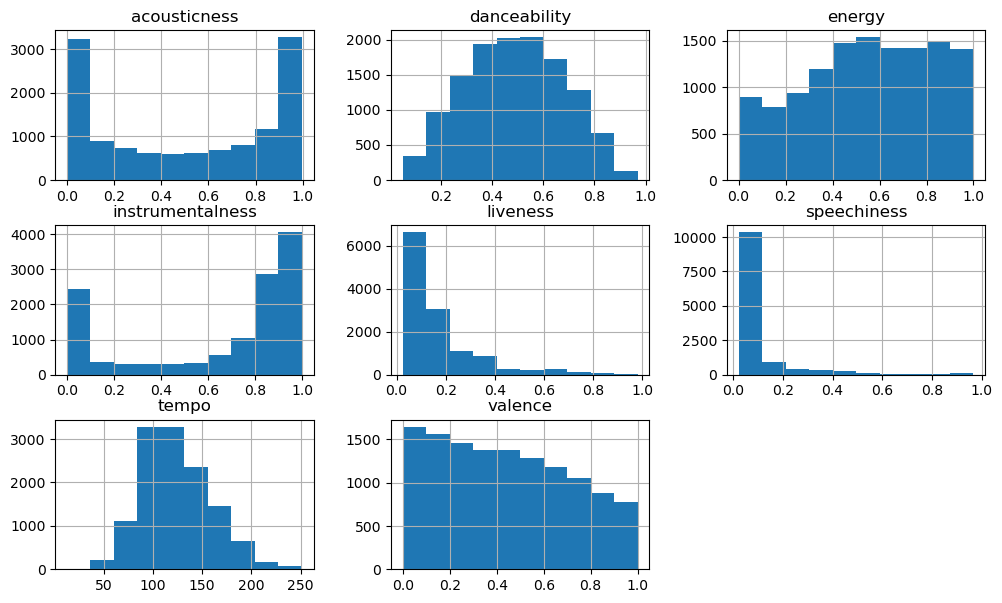

In [5]:
data[audio_features].hist(figsize=(12,7))

# Autoencoder - KMeans Model

In [6]:
# Scale tempo using MinMaxScaler
scaler_tempo = MinMaxScaler()
data['tempo'] = scaler_tempo.fit_transform(data['tempo'].values.reshape(-1, 1))

# Normalize audio features
normalizer_audio = Normalizer()
data[audio_features] = normalizer_audio.fit_transform(data[audio_features])

# Define and train the autoencoder with lower encoding dimension
input_dim = len(audio_features)
encoding_dim = 5  # Reduce dimensionality
input_data = tf.keras.layers.Input(shape=(input_dim,))
encoded = tf.keras.layers.Dense(encoding_dim, activation='relu')(input_data)
decoded = tf.keras.layers.Dense(input_dim, activation='relu')(encoded)
autoencoder = tf.keras.models.Model(input_data, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Train the autoencoder
autoencoder.fit(data[audio_features], data[audio_features], epochs=100, batch_size=256, shuffle=True, verbose=0)

# Extract compressed representation
encoder = tf.keras.models.Model(input_data, encoded)
compressed_representation = encoder.predict(data[audio_features])

# Perform KMeans clustering on compressed representation
km = KMeans(n_clusters=len(major_genres), n_init=100, random_state=1986, verbose=0)
km.fit(compressed_representation)
labels = km.labels_

# Add KMeans labels to data
data['KMeansLabel'] = [f"Cluster {l}" for l in labels]


2024-04-05 13:34:23.213652: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Visualization

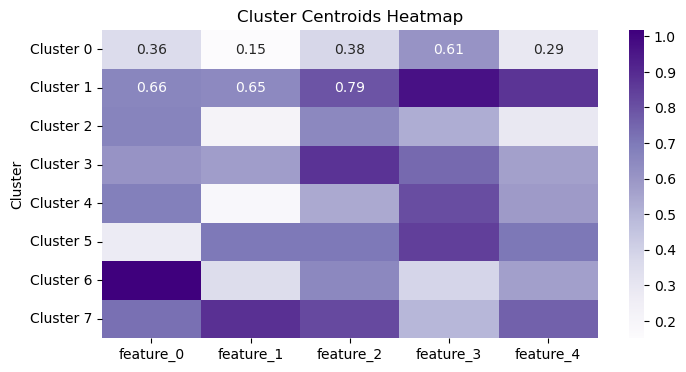

In [7]:
# Get cluster centroids
cluster_centers = km.cluster_centers_

# Create a DataFrame for cluster centroids
km_clusters = pd.DataFrame(cluster_centers, columns=[f'feature_{i}' for i in range(encoding_dim)])

# Add cluster labels
km_clusters['cluster'] = ['Cluster {}'.format(l) for l in range(len(cluster_centers))]

# Plot the heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(
    data=km_clusters.iloc[:, :-1],  # Exclude the last column ('cluster')
    cmap='Purples',
    annot=True,
    yticklabels=km_clusters['cluster']
)
plt.ylabel("Cluster")
plt.title("Cluster Centroids Heatmap")
plt.savefig('./outputs/heatmap_clusters.png')
plt.show()

In [8]:
# mapping clusters identified through audio features to genres
print("Clusters vs genres")
most_common_clusters = data.groupby('genres_top')['KMeansLabel'].agg(lambda x: x.value_counts().index[0]).reset_index()
most_common_clusters.columns = ['genres_top', 'Cluster Number']
most_common_clusters.sort_values(by='Cluster Number')

Clusters vs genres


,genres_top,Cluster Number
6,Rock,Cluster 1
1,Electronic,Cluster 2
0,Classical,Cluster 5
2,Folk,Cluster 5
4,Jazz,Cluster 5
3,Hip-Hop,Cluster 6
5,Pop,Cluster 7


### Principal Component Analysis

In [ ]:
# Apply PCA to reduce dimensions for visualization
pca = PCA(n_components=3)
pca_result = pca.fit_transform(compressed_representation)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

# Create a DataFrame for visualization
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2', 'PC3'])
pca_df['KMeansLabel'] = data['KMeansLabel']

# Plotting
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for label in pca_df['KMeansLabel'].unique():
    label_df = pca_df[pca_df['KMeansLabel'] == label]
    ax.scatter(label_df['PC1'], label_df['PC2'], label_df['PC3'], label=label, s=50)

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('PCA Visualization of KMeans Clusters')
ax.legend(title='Cluster', loc='upper right')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


# Next steps

Given more time, here are some additional steps I would take:
- [ ] Better hyperparameter optimization: At the moment, the hyperparameters used in my models were decided upon through a manual process. A better way to do this would be to set up a grid search procedure where each hyperparameter for both stages of the model (Autoencoder and K-Means).  
  
-  [ ] Visualization: PCA was taking a while to run and due to time constraints, I was unable to let it finish its run. However, the code provided would provide a 3D visualization of the clusters after compressing the dimensions further from 5 to 3 (the autoencoder has already compressed it from 8 to 5).